## Morphological Calls(63x) by Post Patch Outcomes

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import post_patch as pp #post patch script
#post_patch_column = 'postPatch_label'
#post_patch_pipette_column = 'endPipetteR_label'

#sns.set_style('whitegrid') #Makes a white backround with gray horizontal gridmarks at y-values
sns.set_context('notebook')

In [2]:
def get_shiny_df():
    shiny_df = pd.read_csv("C:/users/ramr/documents/github/coding/personal-projects/csv/shiny_mouse.csv")
    shiny_df = shiny_df.loc[:,['sample_id', 'postPatch_label', 'endPipetteR_label']]
    return shiny_df

In [3]:
def get_morph_df():
    morph_df = pd.read_csv("C:/users/ramr/documents/github/coding/personal-projects/csv/63x.csv")
    morph_df = morph_df.loc[:,['patched_cell_container', 'ims63x_go_no_go']]
    return morph_df

In [4]:
def merge_dfs(df1, df2):
    merged_df = pd.merge(left = df1, 
                         right = df2, 
                         left_on = 'patched_cell_container',
                         right_on = 'sample_id',
                         how = 'inner')
    merged_df.drop(['sample_id'], axis = 1, inplace = True)
    return merged_df

In [5]:
def sort_df(final_df):
    #Getting date from patched cell container
    final_df['Date'] = final_df['patched_cell_container'].str[5:11]

    #Changing to string to add 20 in front of strings within date column
    final_df['Date'] = final_df['Date'].astype('str')
    final_df['Date'] = '20' + final_df['Date']
    final_df['Date'] = pd.to_datetime(final_df['Date']) #Converting date to YYYY-MM-DD

    final_df = final_df.set_index('Date') #Set date column as index column

    #start_date = input('Enter the start date for your dataframe (YYYY-MM-DD): ')
    #Production Date Start = '2017-10-01' 
    start_date = '2017-10-01'
    final_df = final_df[start_date:] #Choosing start & end date    

    final_df.rename(columns = {'ims63x_go_no_go' : 'morph'}, inplace = True)
    final_df = pp.postpatch_reclass(final_df)
    
    final_df.drop(['patched_cell_container', 'endPipetteR_label'], axis=1, inplace=True)
    final_df.dropna(subset = ['morph'], inplace = True) #Filters columns that have NaN

    #Categorical
    final_df['morph'] = final_df['morph'].astype('category')
    final_df['post_patch'] = final_df['post_patch'].astype('category')

    final_df.sort_index(inplace = True)
    return final_df

In [6]:
def piv_table(final_df):
    final_df1 = final_df.loc[:,['post_patch', 'morph', 'anno.postPatch_label']]
    final_df1 = final_df.groupby(['post_patch', 'morph']).count()
    final_df1 = final_df1.rename(columns = {'postPatch_label' : ''})
    final_df1.reset_index(inplace = True)

    final_df1 = final_df1.pivot_table(values=[''], 
                                      index=['post_patch'], 
                                      columns = ['morph'], 
                                      aggfunc='sum')
    return final_df1

In [7]:
#Making global variables
shiny_df = get_shiny_df()
morph_df = get_morph_df()
merged_df = merge_dfs(morph_df, shiny_df)
final_df = sort_df(merged_df)
final_df1 = piv_table(final_df)

C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2822: DtypeWarning: Columns (11,109,139,143) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ramr\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

In [10]:
final_df1

morph         63x go 63x no go
post_patch                    
Entire cell        6        14
No-high seal      30        47
No-low seal       12       100
Nuc-high seal    626       269
Nuc-low seal      22       105

In [12]:
#Rusty's Method figure it out later
post_patch_totals = list(final_df1.sum(1))
post_patch_totals = [int(x) for x in post_patch_totals]

In [13]:
final_df1 = final_df1.div(final_df1.sum(1), axis=0) * 100

In [14]:
final_df1

morph             63x go  63x no go
post_patch                         
Entire cell    30.000000  70.000000
No-high seal   38.961039  61.038961
No-low seal    10.714286  89.285714
Nuc-high seal  69.944134  30.055866
Nuc-low seal   17.322835  82.677165

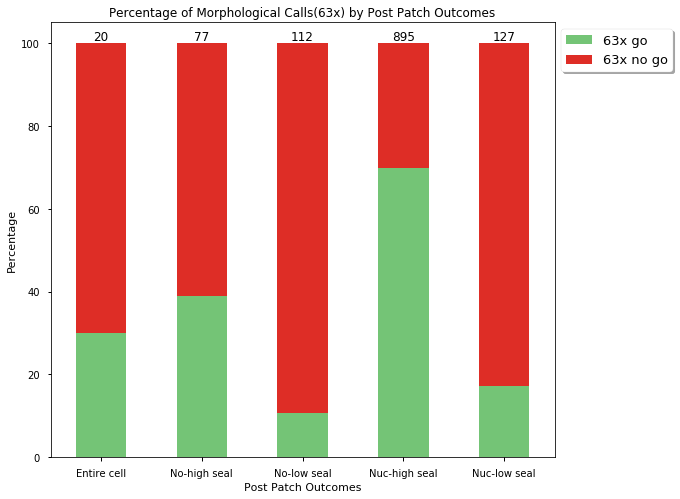

In [15]:
#order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal', 'Entire cell']
#.loc[order] lets you choose the order

my_colors = ['#74c476', '#de2d26']
bp = final_df1.plot.bar(stacked = True, 
                        color = my_colors, 
                        figsize= (10,8),
                        rot = 0)

bp.legend(['63x go', '63x no go'],
          loc = 0, 
          bbox_to_anchor = (1, 1), 
          frameon = True, 
          shadow = True,
          fontsize = 13)

plt.subplots_adjust(left = 0.1, right = 0.8, bottom = None, top = None, wspace=None, hspace=None)
#This helps if axis labels are getting cutoff when saving final image

#Rusty's Method figure it out later
rects = bp.patches
labels = post_patch_totals

#Rusty's Method figure it out later
for rect, label in zip (rects, labels):
    height = 100
    x_value = rect.get_x() + rect.get_width() / 2
    bp.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', size = 12)

bp.set_title('Percentage of Morphological Calls(63x) by Post Patch Outcomes')
bp.set(xlabel = 'Post Patch Outcomes', ylabel = 'Percentage')
plt.savefig('Stacked_Percentage_Barplot_M_by_PP')

[Text(0,0.5,u'Post Patch Outcomes'), Text(0.5,0,u'Percentage')]

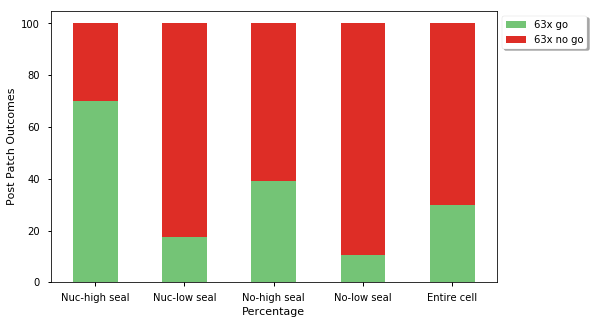

In [16]:
order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal', 'Entire cell']
#.loc[order] lets you choose the order

my_colors = ['#74c476', '#de2d26']
bp = final_df1.loc[order].plot.bar(stacked = True, 
                    color = my_colors,
                    figsize= (8,5),
                    rot = 0)

bp.legend(['63x go', '63x no go'],
          loc = 0, 
          bbox_to_anchor = (1, 1), 
          frameon = True, 
          shadow = True,
          fontsize = 10)

bp.set(xlabel = 'Percentage', ylabel = 'Post Patch Outcomes')